# Chapter 15: The landscape of process behavior charts

For additional context see chapter 15 of [The Virus of Variation & Process Behavior Charts: A Guide for the Perplexed](https://www.brokenquality.com/book).

In [218]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from process_improvement import xmr_charts as xmr
from process_improvement import comparison_charts as cc

%matplotlib inline

## Get data

In [219]:
# Dataset url
dataset_url = r'https://raw.githubusercontent.com/jimlehner/the-virus-of-variation-and-pbcs/refs/heads/main/data/14-electrical-resistance-of-insulation-in-megohms-shewhart-data.csv'

# Get data
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
df = get_data()

# Make 'Year' column dtype string
df['Value'] = df['Value'].astype('string')

# Show df
df.head()

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290


In [220]:
df

,Stage,Value,Resistance
0,Initial,1,5045
1,Initial,2,4350
2,Initial,3,4350
3,Initial,4,3975
4,Initial,5,4290
...,...,...,...
263,Additional,60,4565
264,Additional,61,4210
265,Additional,62,4540
266,Additional,63,4600


## Groupby stage

In [221]:
# Get groups
grouped_df = df.groupby('Stage')

# Create dataframe of initial stage
initial_df = grouped_df.get_group('Initial')
# Create dataframe of only Dublin General data
additional_df = grouped_df.get_group('Additional').reset_index(drop=True)

## Fig 15.1: XmR Chart of initial resistance measurements

In [222]:
# Calculate the moving range
initial_df = initial_df.copy()
initial_df['Moving Ranges'] = abs(initial_df['Resistance'].diff())
initial_df

,Stage,Value,Resistance,Moving Ranges
0,Initial,1,5045,NaN
1,Initial,2,4350,695.0
2,Initial,3,4350,0.0
3,Initial,4,3975,375.0
4,Initial,5,4290,315.0
...,...,...,...,...
199,Initial,200,4625,425.0
200,Initial,201,5150,525.0
201,Initial,202,5250,100.0
202,Initial,203,5000,250.0


In [223]:
# Calculate mean of resistance measurements
mean = round(initial_df['Resistance'].mean(),2)

# Calculate average moving range
average_mR = round(initial_df['Moving Ranges'].mean(),2)

# Set values for the numeric constants C1 and C2
C1 = 2.660
C2 = 3.268

# Calculate the Upper Range Limit
UPL = round(mean + (C1*average_mR),2)
# Calculate the Lower Process Limit
LPL = round(max(0, mean - (C1*average_mR)),2) # Note the max condition 
# Calculate the Upper Range Limit
URL = round(C2*average_mR,2)

# Show the results 
print('UPL:',UPL, 'LPL:',LPL,'URL:',URL)

UPL: 5346.21 LPL: 3650.15 URL: 1041.87


In [224]:
# Define line parameters
xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

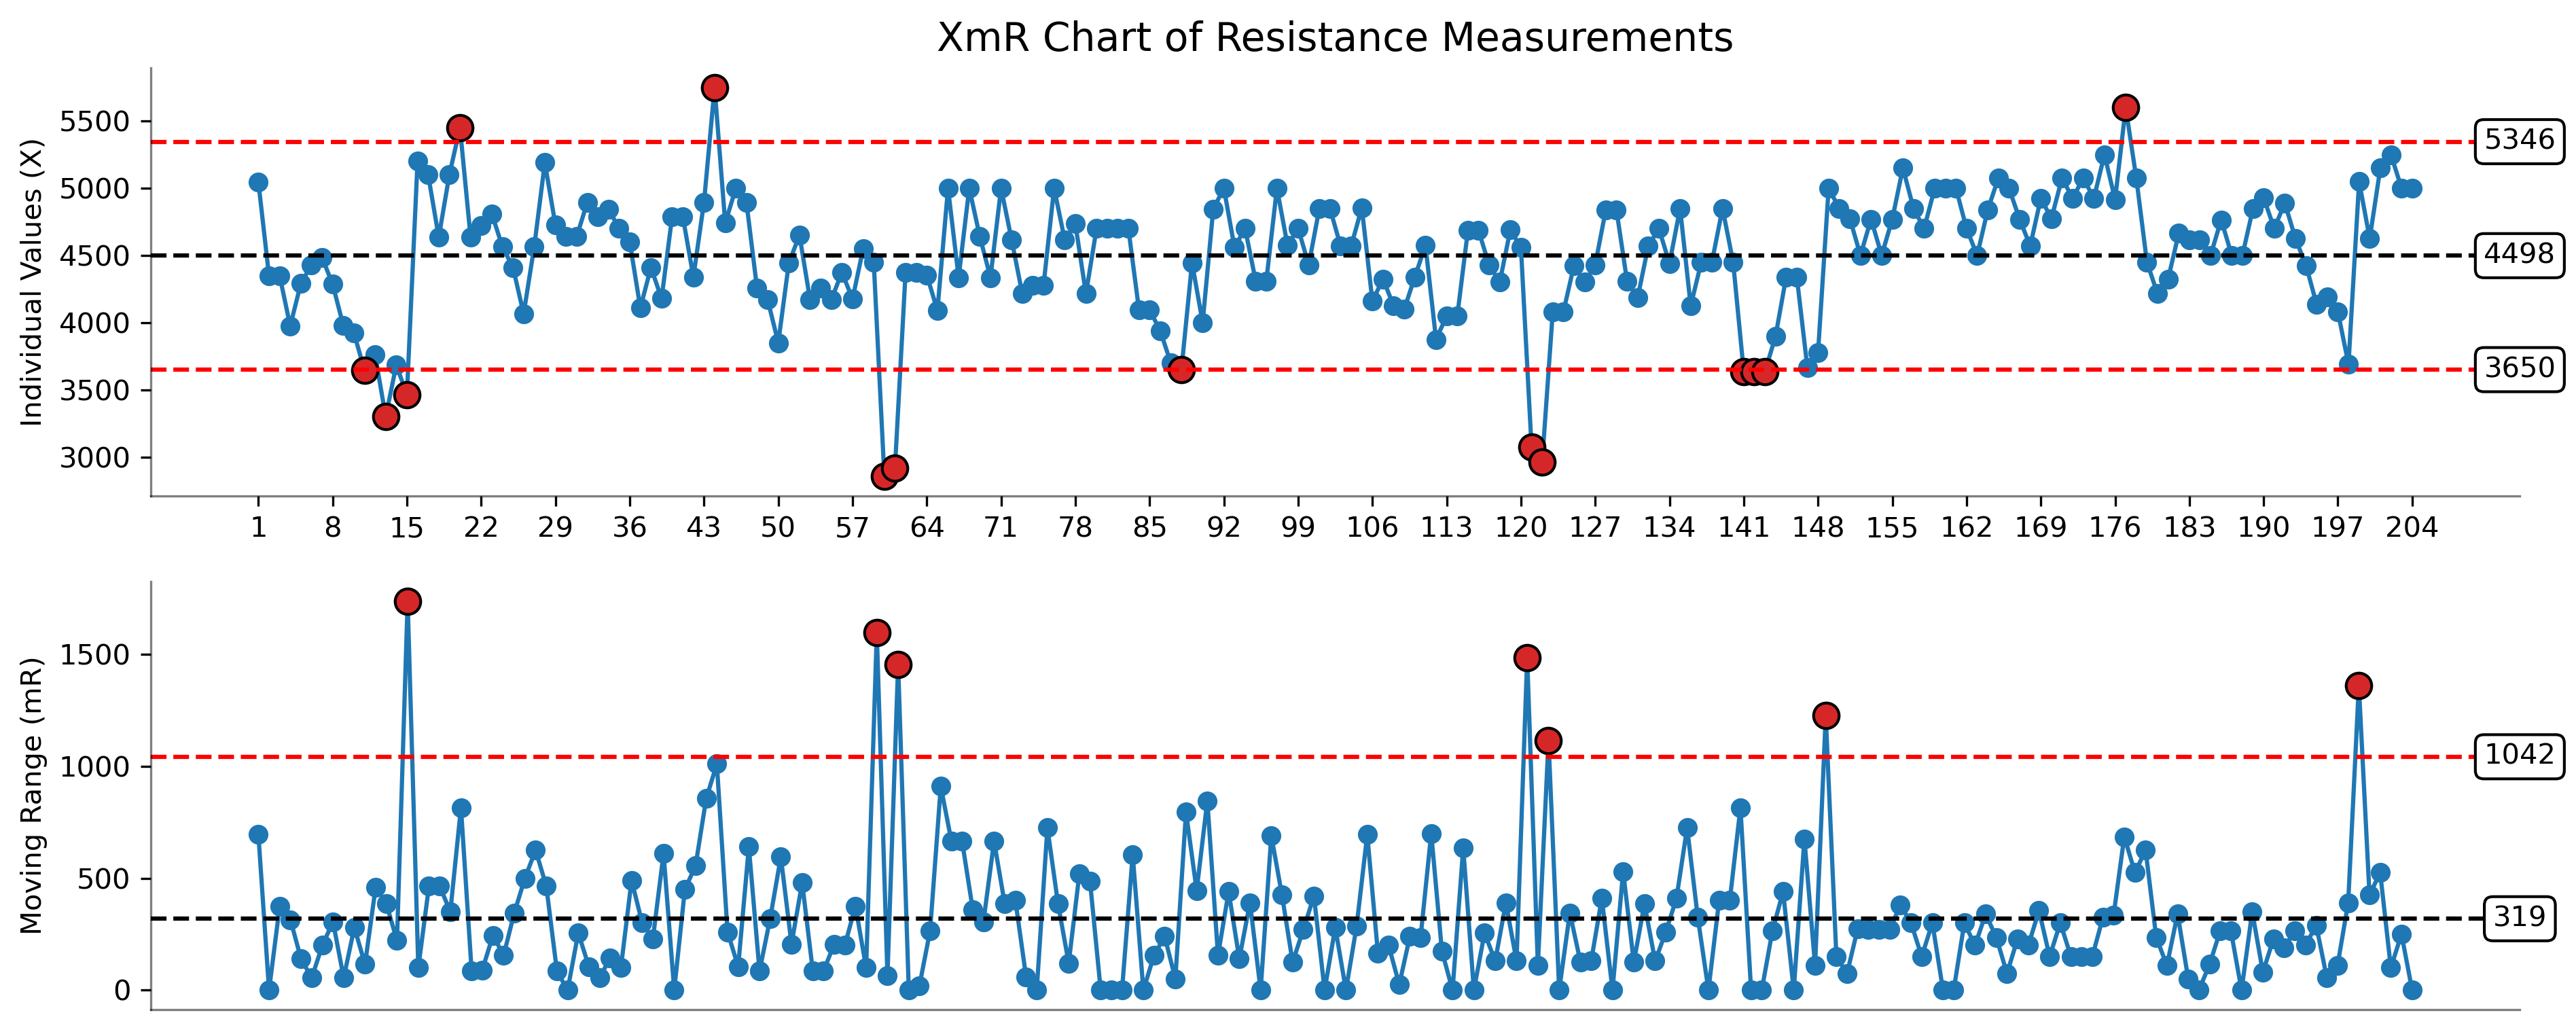

In [225]:
# Extract Data
data = initial_df['Resistance']
labels = initial_df['Value']
moving_ranges = initial_df['Moving Ranges']

# Define Process Limits
xchart_lines = [(mean, 'black'), (UPL, 'red'), (LPL, 'red')]
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]

# Mask values outside limits
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Setup Figure
fig, axs = plt.subplots(figsize=(15, 6), 
                        nrows=2, 
                        ncols=1, 
                        dpi=300)

# X-Chart (Individuals Chart)
axs[0].plot(labels, data, marker='o', label="Data")
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in xchart_lines:
    axs[0].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for value, label in [(UPL, UPL), (LPL, LPL), (mean, mean)]:
    axs[0].text(axs[0].get_xlim()[1] * 1.0, value, round(value),
                color='black', ha='center', va='center', bbox=bbox_props)

# X-Axis Formatting
tick_interval = 7
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')

# Moving Range Chart (mR Chart)
axs[1].plot(labels, moving_ranges, marker='o', label="Moving Range")
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red', markeredgecolor='black', markersize=9)

# Add Process Limits
for value, color in mrchart_lines:
    axs[1].axhline(value, ls='--', c=color)

# Add Labels for Process Limits
for value, label in [(URL, URL), (average_mR, average_mR)]:
    axs[1].text(axs[1].get_xlim()[1], value, round(value),
                color='black', ha='center', va='center', bbox=bbox_props)

# Titles and Labels
axs[0].set_ylabel("Individual Values (X)")
axs[0].set_xlabel("")
axs[0].set_title("")

# Remove xticks on moving range chart
axs[1].set_xticks([])
axs[1].set_ylabel("Moving Range (mR)")

# Remove spines
sns.despine()
# Set alpha values
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)

# Add arrow annotation to highlight May-1847
axs[0].annotate('Hand washing begins\nmid-May 1847', 
             xy=(76.2,12.5), 
             xytext=(89,21), 
             color='black', 
             fontsize=14,
             ha='center',
             arrowprops=dict(facecolor='black'),
             bbox=dict(facecolor='white',boxstyle='round',edgecolor='black'))

# Set titles
axs[0].set_title("XmR Chart of Resistance Measurements", 
                 fontsize=14)

# Show Plot
plt.show()

## Fig 15.2: Average and range chart of initial resistance measurements

Unlike an XmR Chart which is composed of indivdual values and a moving range, the Average and Range Chart is composed of subgroup averages and subgroup ranges. Thus, the first step in building an Average and Range Chart is to **rationally subgroup** the data.

A subgroup is said to be rational when the conditions under which two values are collected are judged to be essentially the same. To achieve this, process knowledge is required. It also imparts a need for homogeneity into the subgroups that favor small subgroup sizes of n=4 to n=10.

### Create rational subgroups for initial resistnace measurements of size n=4

In [226]:
# Calculate the subgroup means
initial_subgrouped = (initial_df['Resistance']
                      .groupby(initial_df.index // 4)
                      .mean()
                      .to_frame()
                      .rename(columns={'Resistance':'Sub Means'})
                     )
initial_subgrouped.head()

,Sub Means
0,4430.00
1,4372.50
2,3827.50
3,3912.00
4,5071.25


In [227]:
# Calculate the subgroup range
initial_subgrouped['Sub Ranges'] = (initial_df['Resistance']
                                    .groupby(initial_df.index // 4)
                                    .agg(lambda x: x.max() - x.min()))
# Add a 'Subgroups' column to subgroup dataframes
initial_subgrouped['Subgroups'] = (pd.Series(np.arange(1, len(initial_subgrouped)+1))
                                   .astype('string'))
initial_subgrouped.head()

,Sub Means,Sub Ranges,Subgroups
0,4430.00,1070,1
1,4372.50,200,2
2,3827.50,335,3
3,3912.00,1900,4
4,5071.25,815,5


### Calculate the grand average and average range

In [228]:
grand_ave = round(initial_subgrouped['Sub Means'].mean(),)
ave_range = round(initial_subgrouped['Sub Ranges'].mean(),)

print('Grand Ave:', grand_ave)
print('Average Range:', ave_range)

Grand Ave: 4498
Average Range: 659


### Calculate process limits for Average and Range Chart

The formulas for the limits on the Average Chart are:
<center> Upper Average Limit = grand average + (A2*average range) <center>
<center> Lower Average Limit = grand average - (A2*average range) <center>

The formulas for the limits on the Range Chart are:
<center> Upper Range Limit = (D4*average range) <center>
<center> Lower Range Limit = (D3*average range) <center>

In [229]:
# Specify A2 for subgroup size n=4
A2 = 0.729
# Specify D3 and D4 for subgroups of size n=4
D3 = -0.282
D4 = 2.282

# Calculate the Average Chart limits
UAL = round(grand_ave + (A2*ave_range))
LAL = round(grand_ave - (A2*ave_range))

# Calculate the Range Chart limits
range_URL = round(D4*ave_range)
range_LRL = max(0, round(D3*ave_range))

# Print results
print("Upper Average Limit:", UAL)
print("Lower Average Limit:", LAL)
print("Upper Range Limit:", range_URL)
print("Lower Range Limit:", range_LRL)

Upper Average Limit: 4978
Lower Average Limit: 4018
Upper Range Limit: 1504
Lower Range Limit: 0


### Build the Average and Range Chart

In [230]:
data = initial_subgrouped['Sub Means']
labels = initial_subgrouped['Subgroups']
moving_ranges = initial_subgrouped['Sub Ranges']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UAL, data)
lower_lim = np.ma.masked_where(data > LAL, data)
# Create masking parameters for values greater than URL on mR-chart
url_greater = np.ma.masked_where(moving_ranges <= range_URL, moving_ranges)
url_less = np.ma.masked_where(moving_ranges > range_LRL, moving_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
average_chart_lines = [(grand_ave,'black'), (UAL,'red'), (LAL,'red')]
range_chart_lines = [(ave_range,'black'), (range_URL,'red'), (range_LRL, 'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
average_chart_labels = [(UAL,UAL),(LAL,LAL),(grand_ave,grand_ave)]
# Create list of tuples with y-coordinate and labels for mR-chart process limit and centerline
range_chart_labels = [(range_URL,range_URL),(ave_range,ave_range)]

### Only the Average Chart

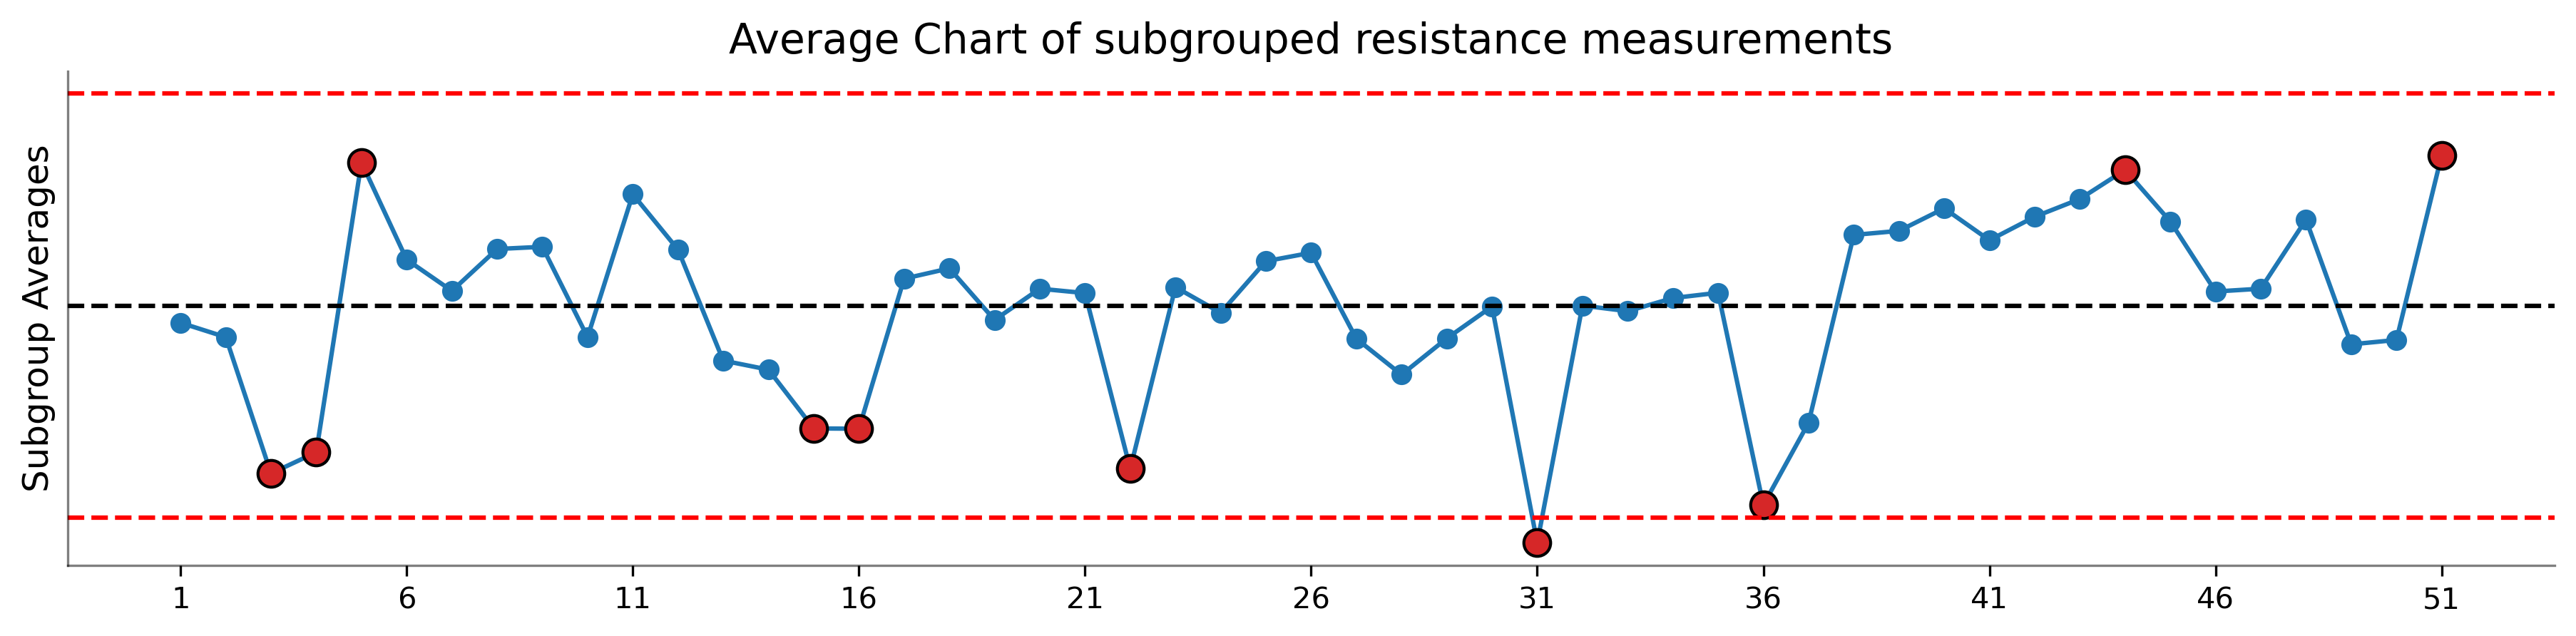

In [231]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

for val in [UAL, LAL, grand_ave]:
    axs[0].text(axs[0].get_xlim()[1], val, val, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in xchart_lines:
    ax.axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = 5  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
ax.set_xlabel("",fontsize=12)
ax.set_ylabel("Subgroup Averages", fontsize=12)
ax.set_title("Average Chart of subgrouped resistance measurements", fontsize=14)
# Remove y tick labels
ax.set_yticks([])

# Despine
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

### Only the Range Chart

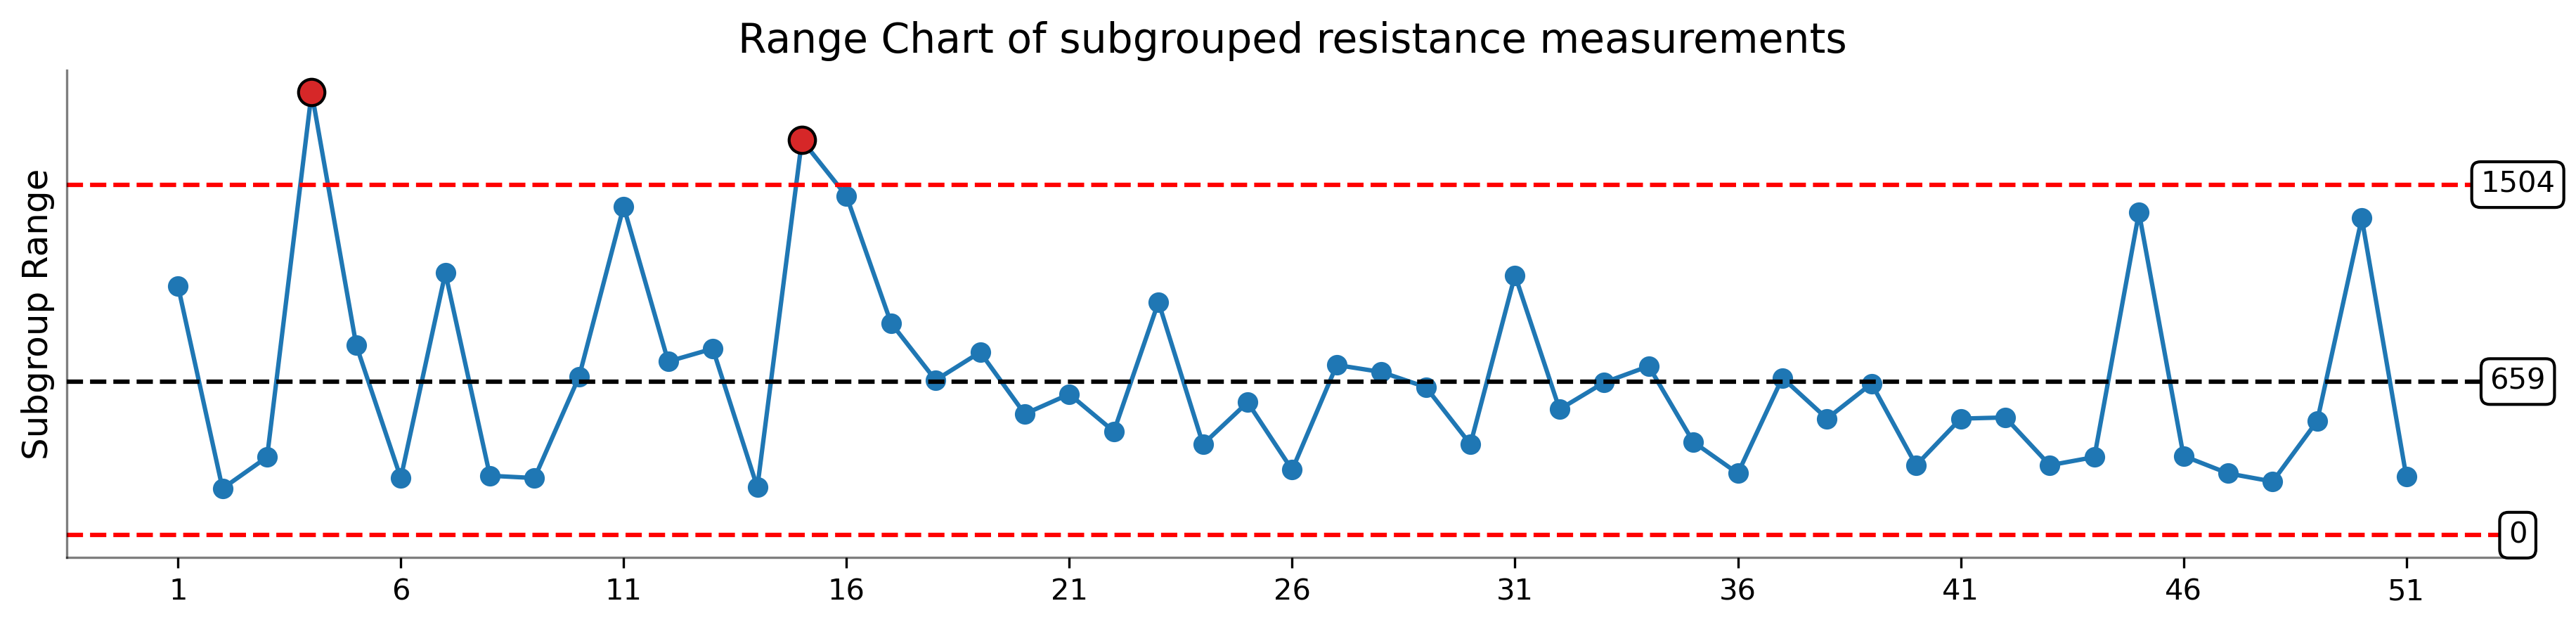

In [232]:
# Generate the X-chart
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

# Plot data 
ax.plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
ax.plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax.plot(labels, url_less, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

for val in [range_URL, range_LRL, ave_range]:
    ax.text(ax.get_xlim()[1], val, val, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in range_chart_lines:
    ax.axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = 5  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
ax.set_xlabel("",fontsize=12)
ax.set_ylabel("Subgroup Range", fontsize=12)
ax.set_title("Range Chart of subgrouped resistance measurements", fontsize=14)
# Remove y tick labels
ax.set_yticks([])

# Specify spine visibility 
sns.despine()
ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

### Fig 15.2: Average and Range Chart

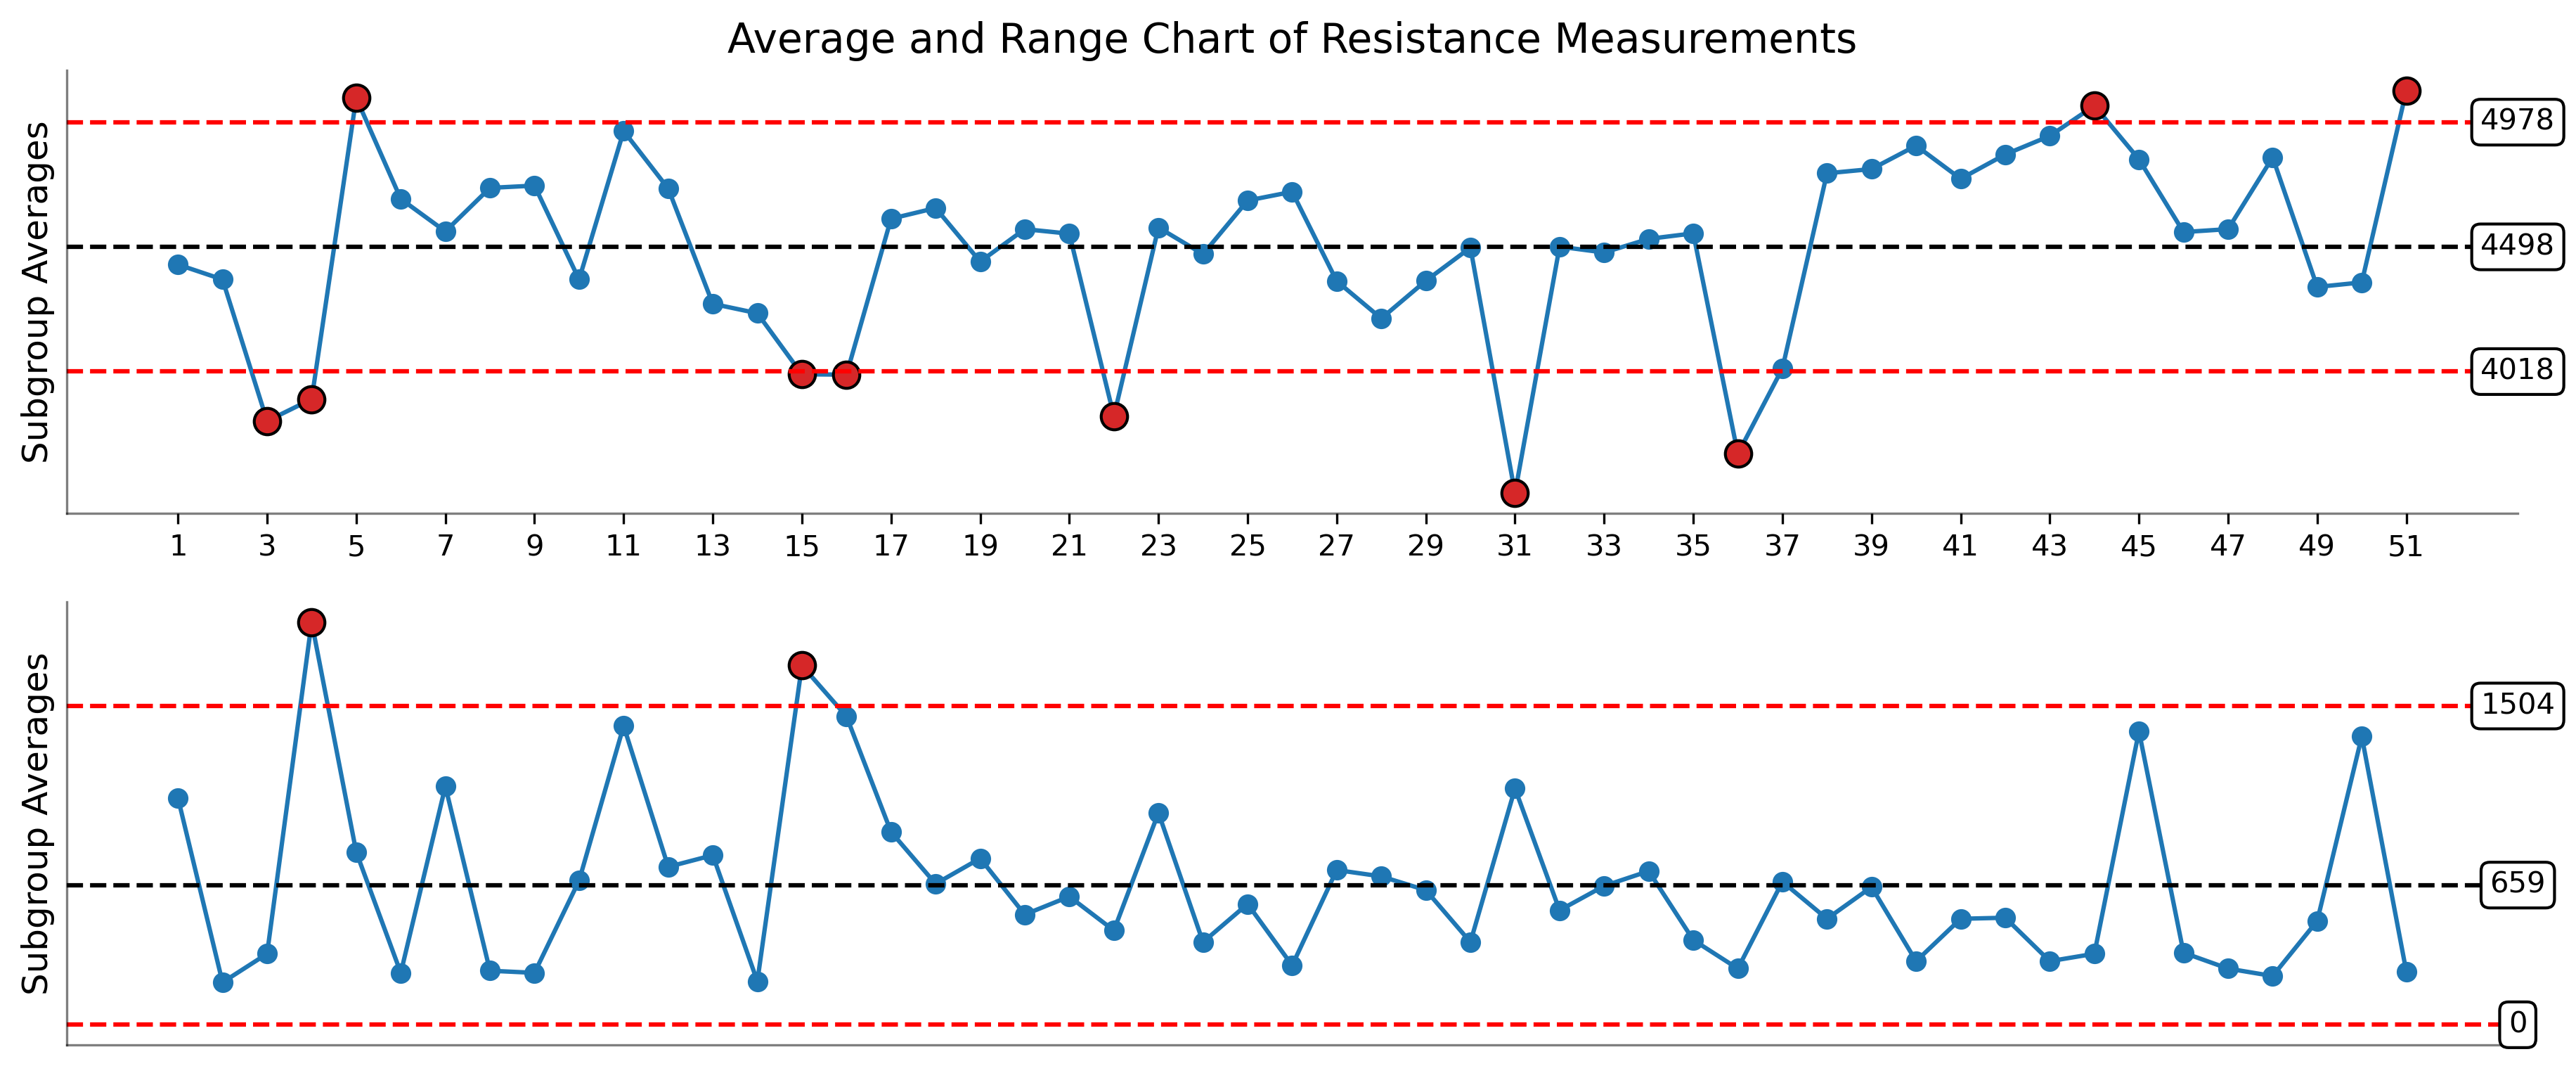

In [233]:
# Generate the X-chart
fig, axs = plt.subplots(figsize=(15,6), nrows=2, ncols=1, dpi=300)

# Plot data 
axs[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
axs[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)

for val in [UAL, LAL, grand_ave]:
    axs[0].text(axs[0].get_xlim()[1], val, val, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in average_chart_lines:
    axs[0].axhline(value, ls='--', c=color)
    
# Plot subgroup ranges on range chart
axs[1].plot(labels, moving_ranges, marker='o')

# Add masking parameters to color values outside process limits
axs[1].plot(labels, url_greater, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
axs[1].plot(labels, url_less, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

for val in [range_URL, range_LRL, ave_range]:
    axs[1].text(axs[1].get_xlim()[1], val, val, color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and process limits 
for value, color in range_chart_lines:
    axs[1].axhline(value, ls='--', c=color)

# # Set the x-tick labels with increased intervals
tick_interval = 2  # Increase this value to increase the spacing between ticks
tick_positions = np.arange(0, len(labels), tick_interval)
axs[0].set_xticks(tick_positions)
axs[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center') 

# Specify axis labels and title
axs[1].set_xlabel("",fontsize=12)
axs[1].set_ylabel("Subgroup Averages", fontsize=12)

# Specify axis labels and title
axs[0].set_xlabel("",fontsize=12)
axs[0].set_ylabel("Subgroup Averages", fontsize=12)

# Remove y tick labels
axs[0].set_yticks([])
axs[1].set_yticks([])
# Remove x ticks on Range Chart
axs[1].set_xticks([])

# Despine
sns.despine()
for val in range(0,2):
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Set titles
axs[0].set_title("Average and Range Chart of Resistance Measurements", 
                 fontsize=14)

# Show plot
plt.show()

## Fig 15.3: Comparison of X Chart and Average Chart

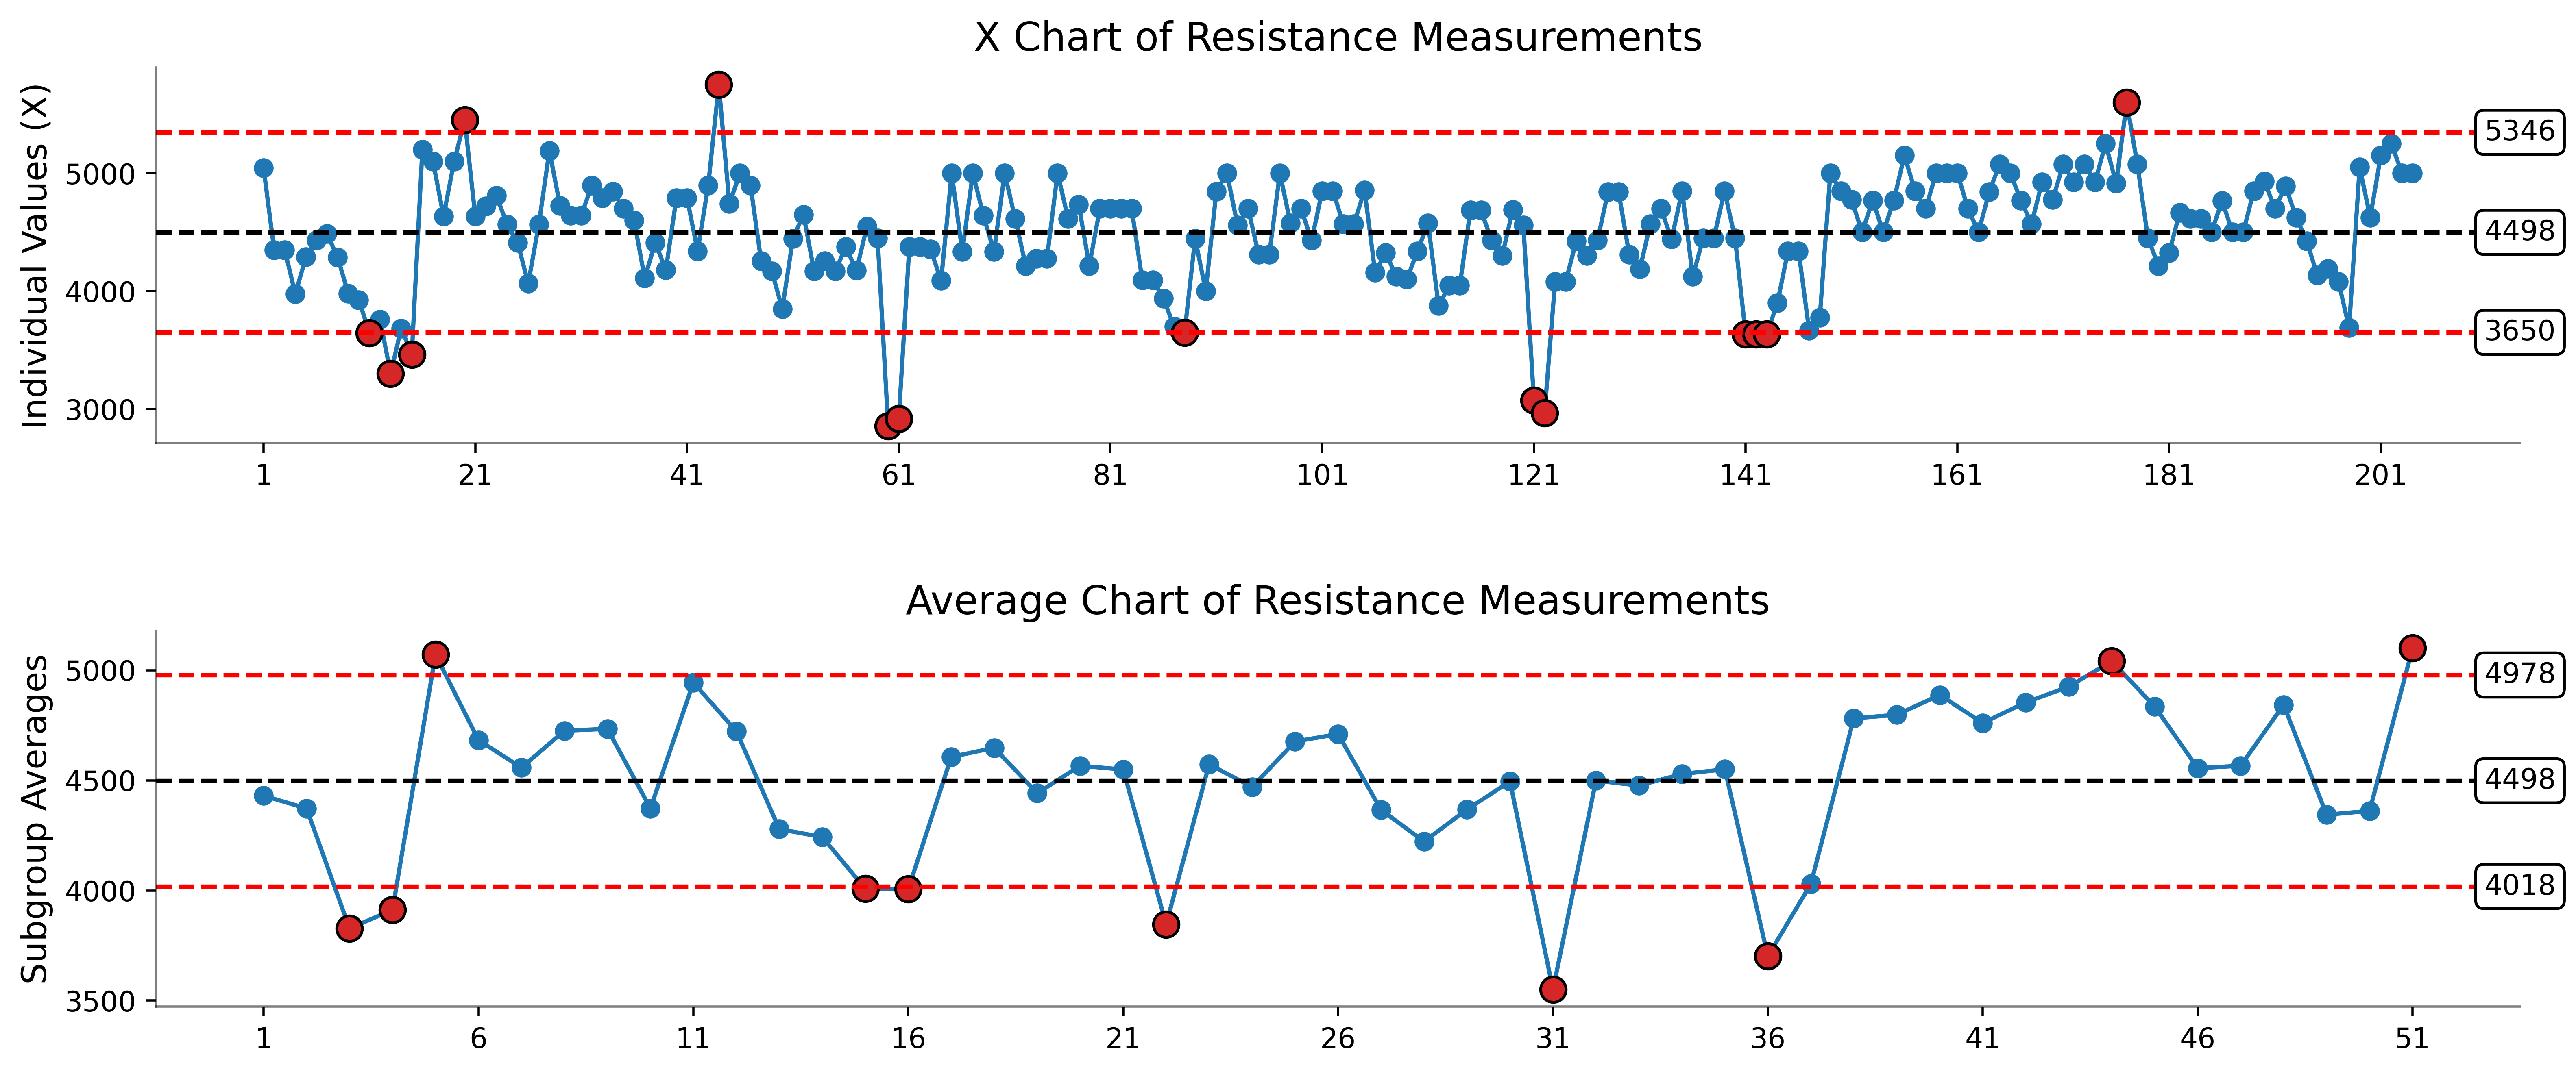

In [234]:
# Specify tickinterval
tickinterval = 10
round_value=2

# Disaggregate the dataframe 
data = initial_df["Resistance"]
labels = initial_df["Value"]

subgrouped_data = initial_subgrouped['Sub Means']
subgrouped_labels = initial_subgrouped['Subgroups']

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)
# Create masking parameters for values greater than and less than the process limits on X-chart
subgrouped_upper_lim = np.ma.masked_where(subgrouped_data < UAL, subgrouped_data)
subgrouped_lower_lim = np.ma.masked_where(subgrouped_data > LAL, subgrouped_data)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]
averagechart_lines = [(grand_ave,'Black'),(LAL,'red'),(UAL,'red')]
# Create list of tuples with y-coordinate and labels for x-chart process limits and centerline 
xchart_labels = [(UPL,UPL),(LPL,LPL),(mean,mean)]
average_chart_labels = [(UAL),(LAL),(grand_ave,grand_ave)]

# Generate the X-chart
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,6), dpi=500)#, sharey=True)
plt.subplots_adjust(hspace=0.5)

# Plot X Chart data
ax1.plot(labels, data, marker='o')
# Plot Average Chart data
ax2.plot(subgrouped_labels, subgrouped_data, marker='o')

# Add masking parameters to color values outside process limits
ax1.plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax1.plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add masking parameters for Average chart
ax2.plot(subgrouped_labels, subgrouped_lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax2.plot(subgrouped_labels, subgrouped_upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for val in [UPL, LPL, mean]:
    ax1.text(ax1.get_xlim()[1], val, round(val), color='black', ha='center', va='center', bbox=bbox_props)
for val in [UAL, LAL, grand_ave]:
    ax2.text(ax2.get_xlim()[1], val, round(val), color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and limits to X Chart
for value, color in xchart_lines:
    ax1.axhline(value, ls='--', c=color)
# Add centerline and limits to Average Chart
for value, color in average_chart_lines:
    ax2.axhline(value, ls='--', c=color)

# Specify spine visibility 
sns.despine()

# # Set the x-tick labels with increased intervals
tick_interval_1 = 20  # Increase this value to increase the spacing between ticks
tick_interval_2 = 5
tick_positions_1 = np.arange(0, len(labels), tick_interval_1)
tick_positions_2 = np.arange(0, len(subgrouped_labels), tick_interval_2)

# Set xticks for X Chart
ax1.set_xticks(tick_positions_1)
ax1.set_xticklabels(labels.iloc[tick_positions_1], rotation=0, ha='center') 
# Set xticks for Average Chart
ax2.set_xticks(tick_positions_2)
ax2.set_xticklabels(subgrouped_labels.iloc[tick_positions_2], rotation=0, ha='center') 

# Specify axis labels and title
plt.xlabel("",fontsize=12)
ax1.set_ylabel("Individual Values (X)", fontsize=12)
ax2.set_ylabel("Subgroup Averages", fontsize=12)

# Set titles
ax1.set_title("X Chart of Resistance Measurements", fontsize=14)
ax2.set_title("Average Chart of Resistance Measurements", fontsize=14)

# Set alpha for spines
for ax in (ax1, ax2):
    ax.spines[['left','bottom']].set_alpha(0.5)

# Show plot
plt.show()

## Fig 15.4: Comparison of mR Chart and Range Chart

In [235]:
# Calculate the Upper Range Limit
URL = round(C2*average_mR,2)

# Specify D3 and D4 for subgroups of size n=4
D3 = -0.282
D4 = 2.282
# Calculate the Range Chart limits
range_URL = round(D4*ave_range)
range_LRL = max(0, round(D3*ave_range))

In [236]:
# Specify tickinterval
tickinterval = 10

# Disaggregate the dataframe 
data = initial_df["Resistance"]
moving_ranges = initial_df['Moving Ranges']
labels = initial_df["Value"]

subgrouped_ranges = initial_subgrouped['Sub Ranges']
subgrouped_labels = initial_subgrouped['Subgroups']

# Define line parameters
mrchart_lines = [(average_mR, 'black'), (URL, 'red')]
# Mask values outside limits
url_greater = np.ma.masked_where(moving_ranges <= URL, moving_ranges)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UAL, data)
lower_lim = np.ma.masked_where(data > LAL, data)
# Create masking parameters for values greater than URL on mR-chart
subgrouped_url_greater = np.ma.masked_where(subgrouped_ranges <= range_URL, subgrouped_ranges)
subgrouped_url_less = np.ma.masked_where(subgrouped_ranges > range_LRL, subgrouped_ranges)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
range_chart_lines = [(ave_range,'black'), (range_URL,'red'), (range_LRL, 'red')]
range_chart_labels = [(range_URL,range_URL),(ave_range,ave_range)]

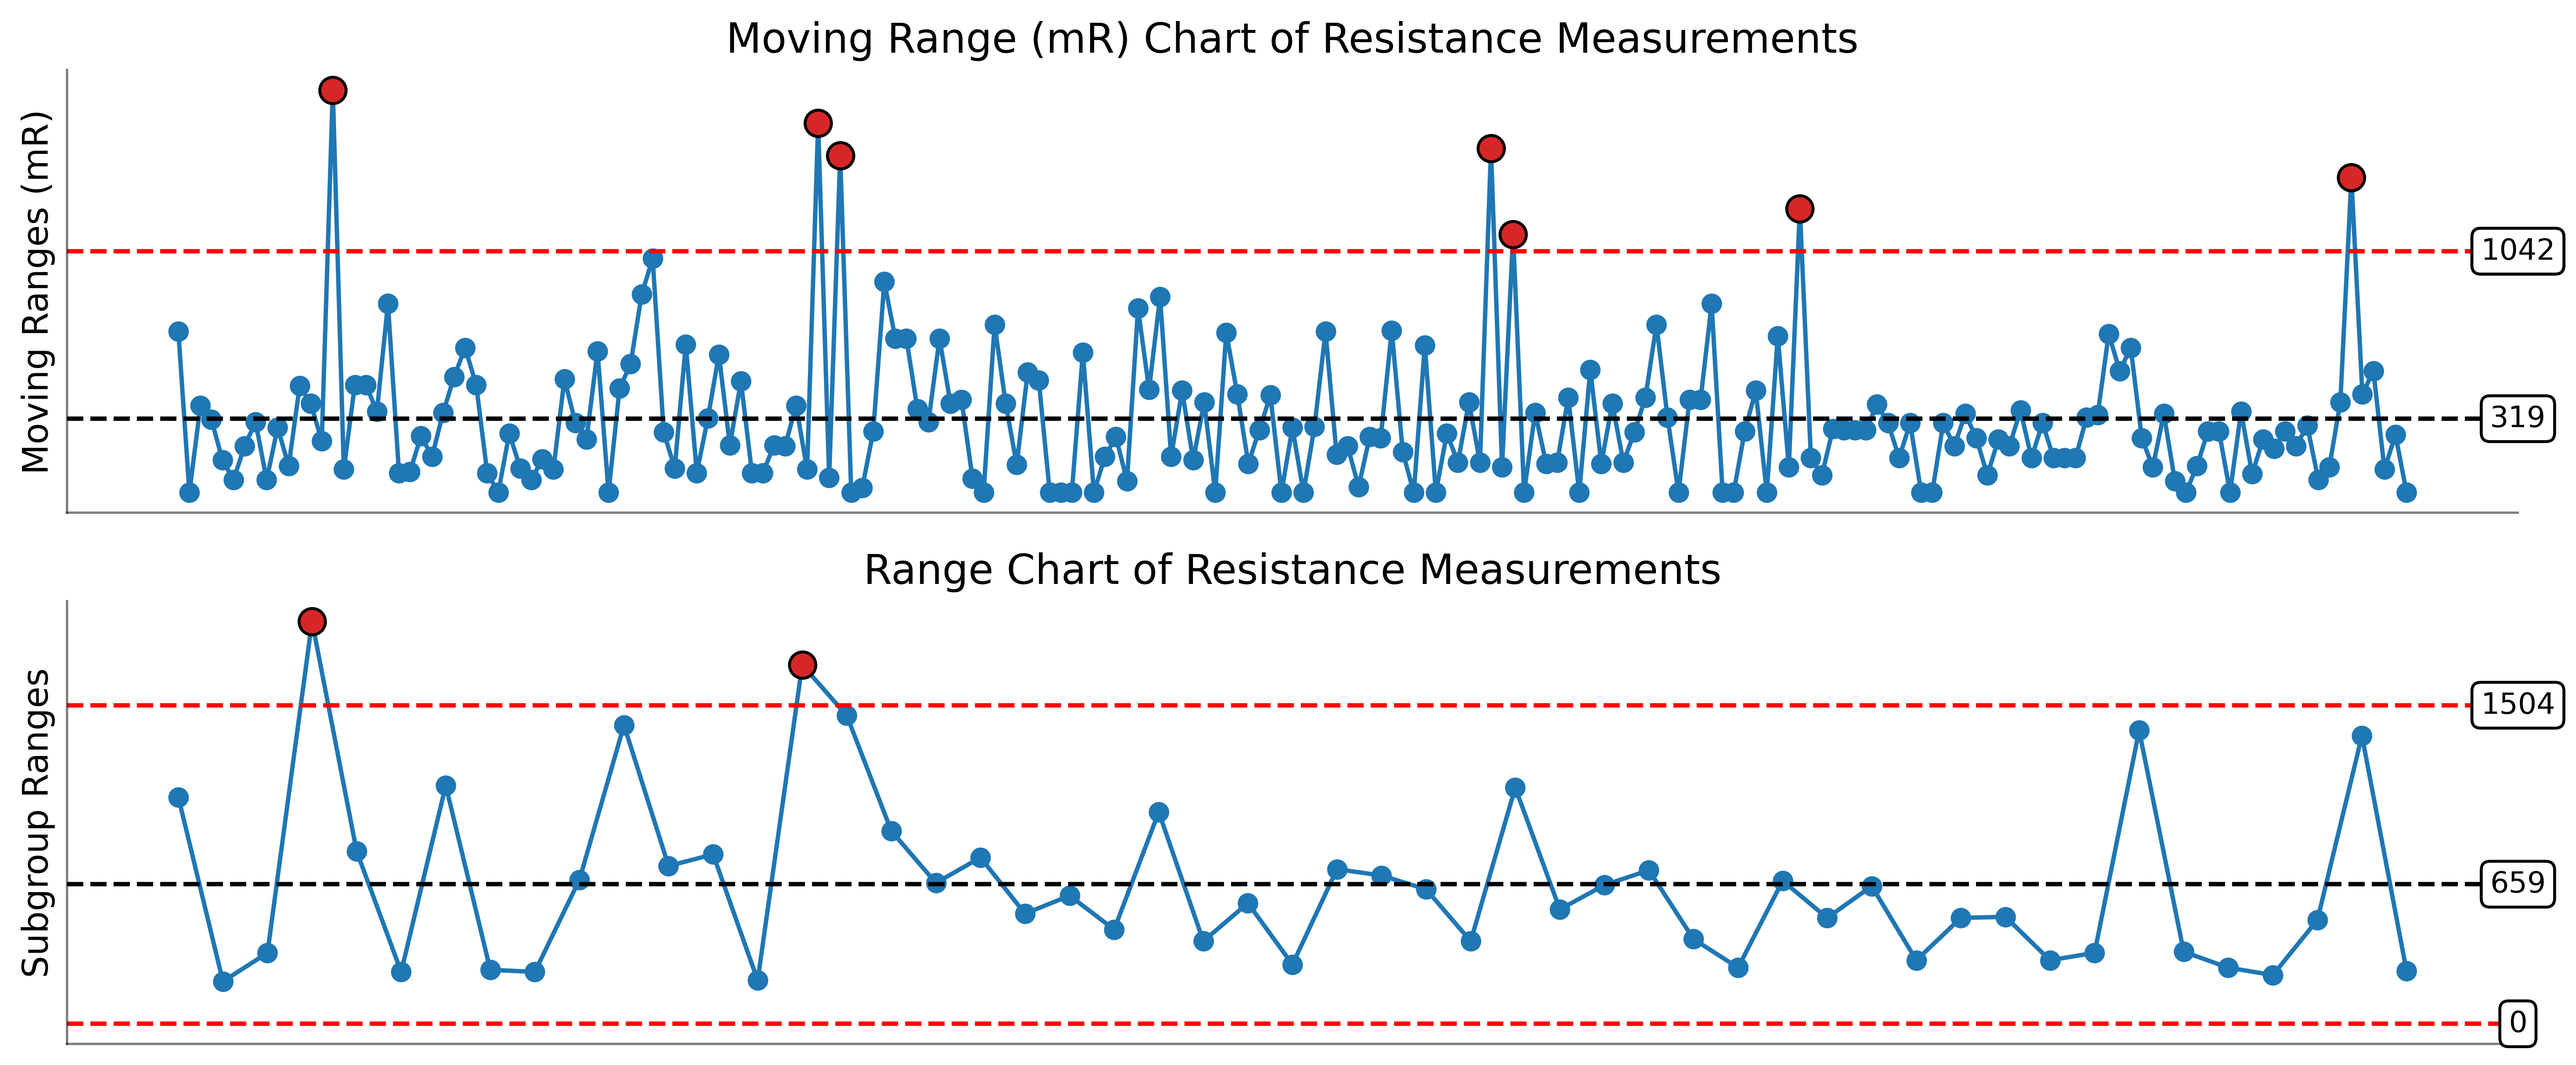

In [237]:
# Create figure and axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,6), dpi=500)

# Moving Range Chart (mR Chart)
axs[0].plot(labels, moving_ranges, marker='o')
# Masking parameters mR Chart
axs[0].plot(labels, url_greater, marker='o', ls='none', 
            color='tab:red', markeredgecolor='black', markersize=9)
# Masking paramters for Range Chart
axs[1].plot(subgrouped_labels, subgrouped_ranges, marker='o')
axs[1].plot(subgrouped_labels, subgrouped_url_greater, marker='o', 
            color='tab:red', markeredgecolor='black', markersize=9)

# Add text labels for limits and centerline
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1)
for val in [URL, URL, average_mR]:
    axs[0].text(axs[0].get_xlim()[1], val, round(val), color='black', ha='center', va='center', bbox=bbox_props)
for val in [range_URL, range_LRL, ave_range]:
    axs[1].text(axs[1].get_xlim()[1], val, round(val), color='black', ha='center', va='center', bbox=bbox_props)

# Add centerline and limits to X Chart
for value, color in mrchart_lines:
    axs[0].axhline(value, ls='--', c=color)
# Add centerline and limits to Average Chart
for value, color in range_chart_lines:
    axs[1].axhline(value, ls='--', c=color)

# Despine
sns.despine()
# Remove xticks and yticks for both plots
for val in range(0,2):
    axs[val].set_xticks([])
    axs[val].set_yticks([])
    axs[val].spines[['left','bottom']].set_alpha(0.5)
    
# Set titles
axs[0].set_title("Moving Range (mR) Chart of Resistance Measurements", fontsize=14)
axs[1].set_title("Range Chart of Resistance Measurements", fontsize=14)

# Specify axis labels and title
plt.xlabel("",fontsize=12)
axs[0].set_ylabel("Moving Ranges (mR)", fontsize=12)
axs[1].set_ylabel("Subgroup Ranges", fontsize=12)

# Show plot
plt.show()